Source: https://www.youtube.com/watch?v=2VwPnQeZNMA&list=PL4ho7ag3cJzU3O4taotUpFL6b1InP9vRs&index=1

# Introdução

Este projeto é um repodyção do vídeo presente no canal do youtube [WisdowML]().

A ideia do projeto é de classificação de textos, utilizando NLP.

O algoritmo que principal utilizado para este estudo é classificador passivo-agressivo.

Ele também é um algoritmo de rede neural, similar ao Preceptron. Seu foco é em classificação, e por serem algoritmos chamados online, eles aprendem em forma de streaming, atualizando o aprendizado em tempo real.

Artigos que podem explicar melhor o algoritmo.

* [Vitalux](https://vitalflux.com/passive-aggressive-classifier-concepts-examples/#:~:text=The%20passive%20aggressive%20classifier%20is,2006%20by%20Crammer%20et%20al.) em inglês
* [Acervo Silva](https://acervolima.com/classificadores-passivos-agressivos/)

## Conjunto de dados

O connjunto de dados utilizado está disponivél na [UCI](https://archive.ics.uci.edu/ml/index.php), um repositório com diversos tipos de conjuntos de dados para análise e criação de modelos.

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip


--2023-05-27 17:07:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip.1’

drugsCom_raw.zip.1  100%[===================>]  41.00M  55.4MB/s    in 0.7s    

2023-05-27 17:07:45 (55.4 MB/s) - ‘drugsCom_raw.zip.1’ saved [42989872/42989872]



In [3]:
!unzip /content/drugsCom_raw.zip


Archive:  /content/drugsCom_raw.zip
replace drugsComTest_raw.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Bibliotecas Utilizadas

In [4]:
# Manipulaçao dos dados e visualizações
import pandas as pd
import itertools #matriz de confusão
import string # facilita a manipulação de strings
import numpy as np # Utilizado para criar e manipula vetores e matrizes
import seaborn as sns # Ulitazado para criar gráficos. Acho ele mais simples que o matplotib, apesar dessa biblioteca funcionar debaixo dos planos.
import matplotlib.pyplot as plt

# Treino e manipulação dos modelos
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics



In [5]:
#Faz as nossas visulaizações aparecem direto no notebook. Sem warnings chatos
%matplotlib inline 

pd.set_option('display.max_rows',None)

# Avaliando o Conjunto de 



In [6]:
df=pd.read_csv('/content/drugsComTrain_raw.tsv', sep='\t')

In [7]:
df.head()

Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           10  
4  November 27, 2016           37

In [8]:
## Número de Indicações
df.condition.value_counts()

Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                                     2321

In [9]:
# Selecionando as indicações clínicas
df_video_treino=df[(df['condition']=='Birth Control') | (df['condition']=='Depression') | (df['condition']=='High Blood Pressure') | (df['condition']=='Diabetes, Type 2')]

In [10]:
# Irei selecionar algumas outras indicacoes clínicas. Escolhe algumas das mais comuuns que via no meu tempode de drogaria.
# Como a maioria dos médicamentos para trata-las são de venda livre, ou não necessitavam de retenção de receita, eram vendidas com bastante frequencia.
df_meu_treino=df[(df['condition']=='Erectile Dysfunction') | (df['condition']=='Sinusitis ') | (df['condition']=='Diarrhea') | (df['condition']=='Emergency Contraception') | (df['condition']=='Pain') | (df['condition']=='Allergies')]

In [11]:
df.shape

(161297, 7)

In [12]:
df_video_treino.shape

(42732, 7)

In [13]:
df_meu_treino.shape

(9983, 7)

In [14]:
# Selecioando as features
X=['Unnamed: 0','drugName','rating','date','usefulCount']

In [15]:
X_aula=df_video_treino.drop(X,axis=1)
X_meu=df_meu_treino.drop(X,axis=1)

# Análise Exploraórioa dos Dados (EDA)

Nessa etapa o objetivo é avaliar os dados que temos no conjunto de treino.

In [16]:
X_aula.condition.value_counts()

Birth Control          28788
Depression              9069
Diabetes, Type 2        2554
High Blood Pressure     2321
Name: condition, dtype: int64

In [17]:
X_meu.condition.value_counts()

Pain                       6145
Emergency Contraception    2463
Erectile Dysfunction       1086
Allergies                   179
Diarrhea                    110
Name: condition, dtype: int64

In [18]:
X_aula.head()

condition                                             review
2   Birth Control  "I used to take another oral contraceptive, wh...
3   Birth Control  "This is my first time using any form of birth...
9   Birth Control  "I had been on the pill for many years. When m...
11     Depression  "I have taken anti-depressants for years, with...
14  Birth Control  "Started Nexplanon 2 months ago because I have...

In [19]:
X_meu.head()

condition                                             review
6   Emergency Contraception  "He pulled out, but he cummed a bit in me. I t...
32                     Pain  "I am 30 years old. I had a multiple composite...
37                     Pain  "I have been on morphine for at least 7 years....
52                     Pain  "My pain management doctor put me on Butrans p...
62                     Pain  "I love my Butrans patch!!! And it has relieve...

In [20]:
# Separando o dataframe para analizar cada indicação de forma separada
X_birth=X_aula[(X_aula['condition']=='Birth Control')]
X_dep=X_aula[(X_aula['condition']=='Depression')]
X_bp=X_aula[(X_aula['condition']=='High Blood Pressure')]
X_diab=X_aula[(X_aula['condition']=='Diabetes, Type 2')]
X_pain=X_meu[(X_meu['condition']=="Pain")]
X_contra=X_meu[(X_meu['condition']=='Emergency Contraception')]
X_alerg=X_meu[(X_meu['condition']=='Allergies')]
X_erec=X_meu[(X_meu['condition']=='Erectile Dysfunction')]
X_diarr=X_meu[(X_meu['condition']=='Diarrhea')]



In [21]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
# Criando nuvens de palavras
from wordcloud import WordCloud

Text(0.5, 1.0, 'Word cloud for Birth control')

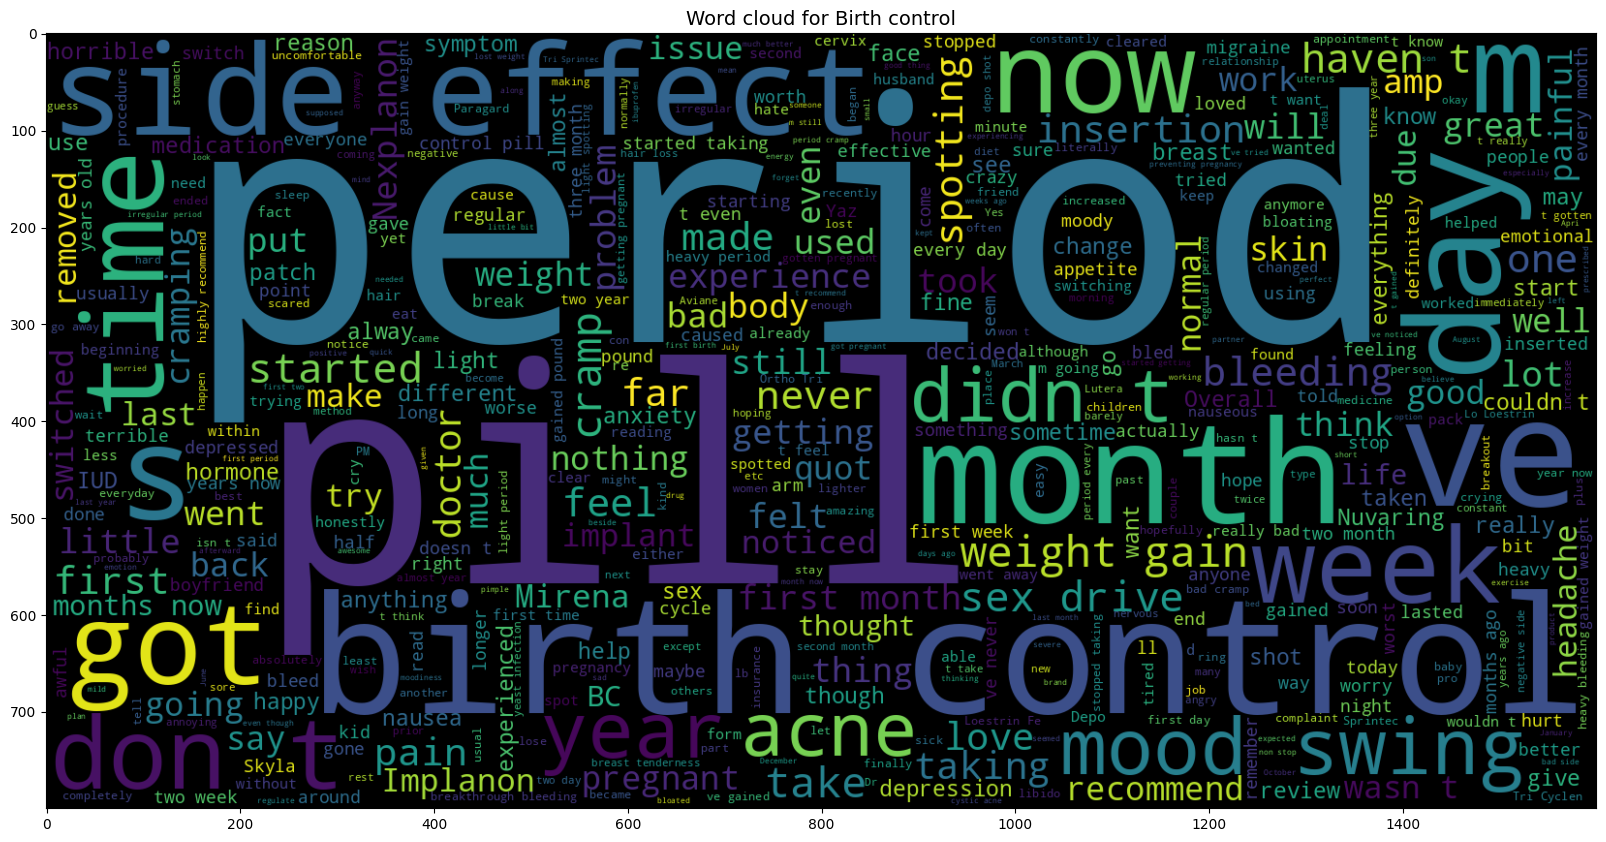

In [23]:
plt.figure(figsize=(20,20)) 

# É necessário ter uma lista como entrada. Paral tal é utilizado um método generate, que tem como entrada uma llst comprehensio, que transforma o array em uma lista.
wc= WordCloud(max_words=500, width=1600, height=800).generate(" ".join(X_birth.review))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word cloud for Birth control',fontsize=14)

Obs: Eu fiquei em dúvida sobre o parametro interpolation/interpolação. <br /><br />
Em resumo, a função desse parâmetro é modificar a resolução da imagem. <br /><br />
Resolução é a capacidade do olho humano em distinguir objetos de uma imagens, ou seja, captar seus detalhes. Ela está relacionada ao número de pixels  <br /><br />

A interpolação tem a capaciadade de aumentar o número de pixels em imagems. <br/>
<br/>
Alguns artigos sobre:
* [Daniel Ishida](https://www.midializado.com.br/2011/06/o-que-e-interpolacao-de-imagem/)

* [Tecmundon](https://www.tecmundo.com.br/blu-ray/2917-interpolacao-de-imagens.htm)
* [Documentação da biblioteca - antialiasing ](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_antialiasing.html)
* [Documentação da bilioteca- interpolation](https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html)

* [Canal Tech sobre resolição](https://canaltech.com.br/software/resolucao-de-imagem-o-que-e/)



Text(0.5, 1.0, 'Word cloud for Allergies')

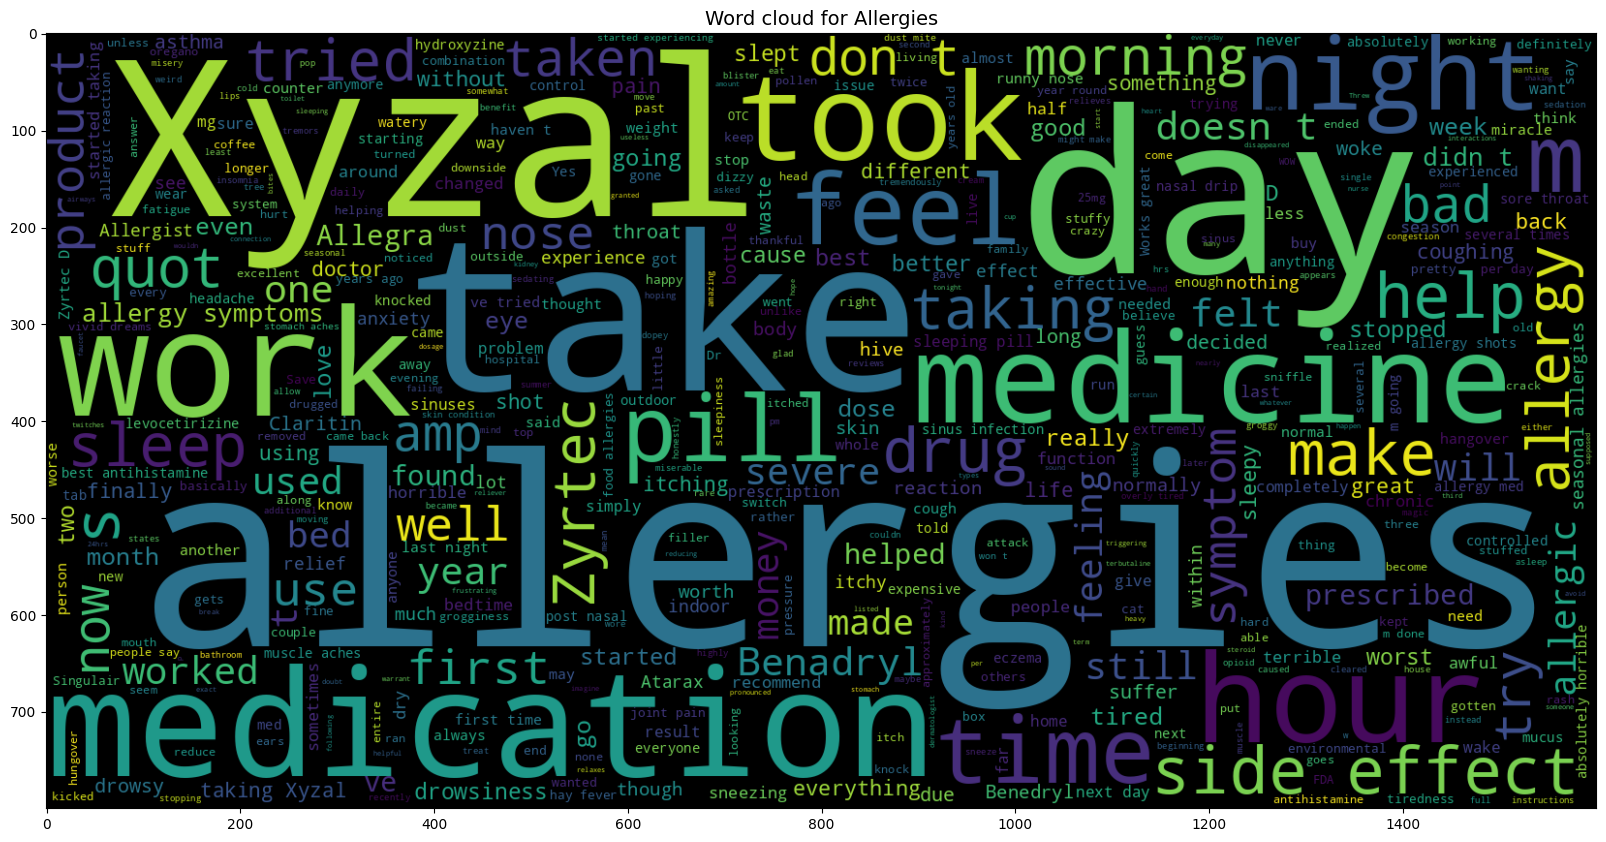

In [24]:
plt.figure(figsize=(20,20)) 
wc= WordCloud(max_words=500, width=1600, height=800).generate(" ".join(X_alerg.review))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word cloud for Allergies',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Depression')

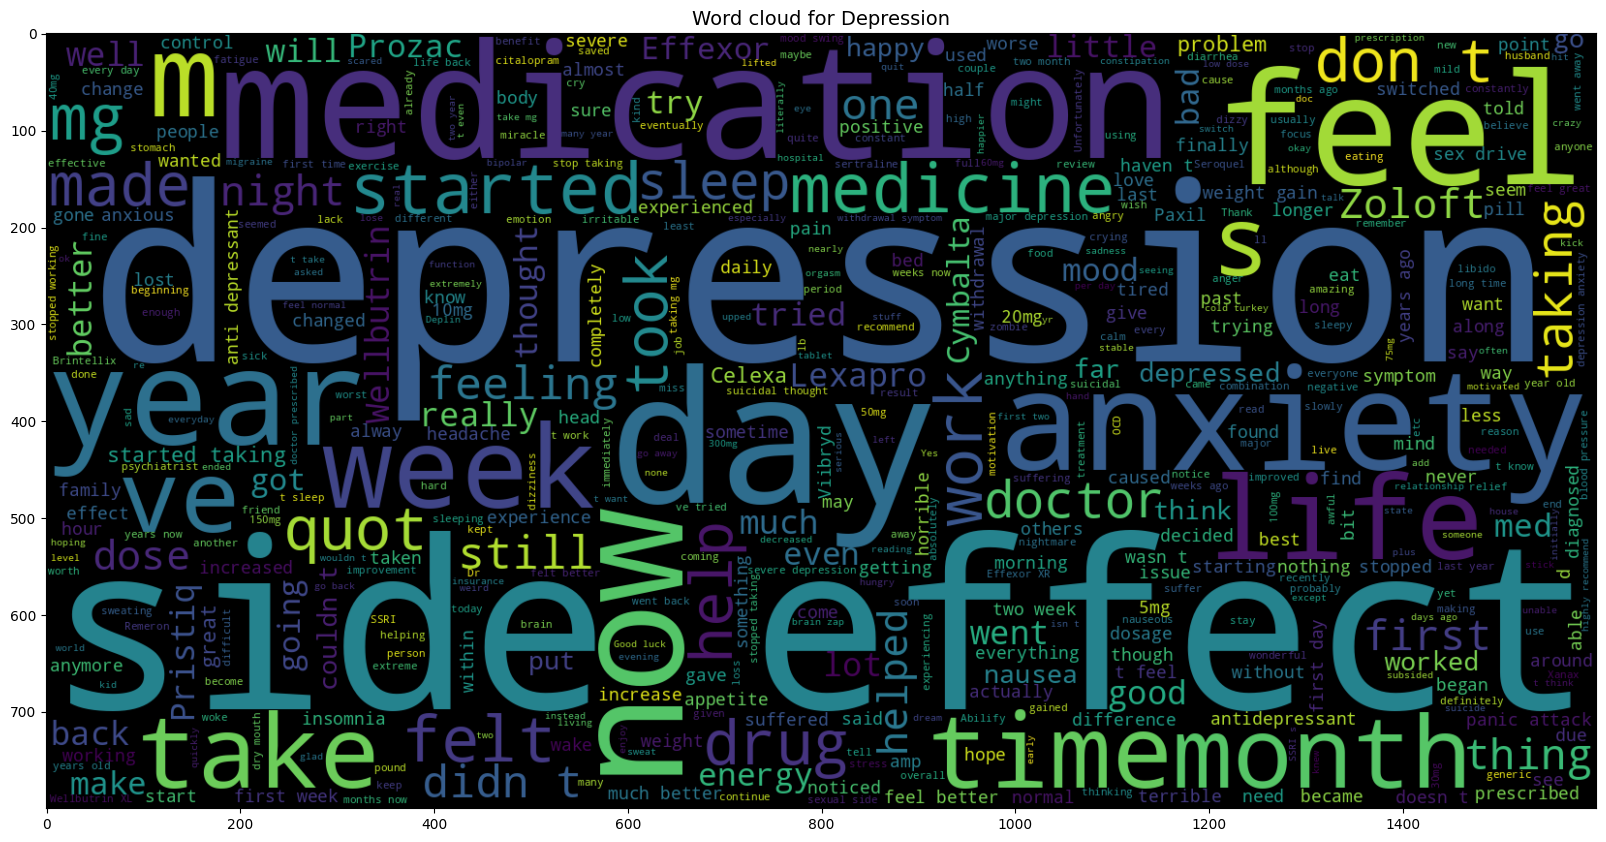

In [25]:
plt.figure(figsize=(20,20)) 
wc= WordCloud(max_words=500, width=1600, height=800).generate(" ".join(X_dep.review))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word cloud for Depression',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Pain')

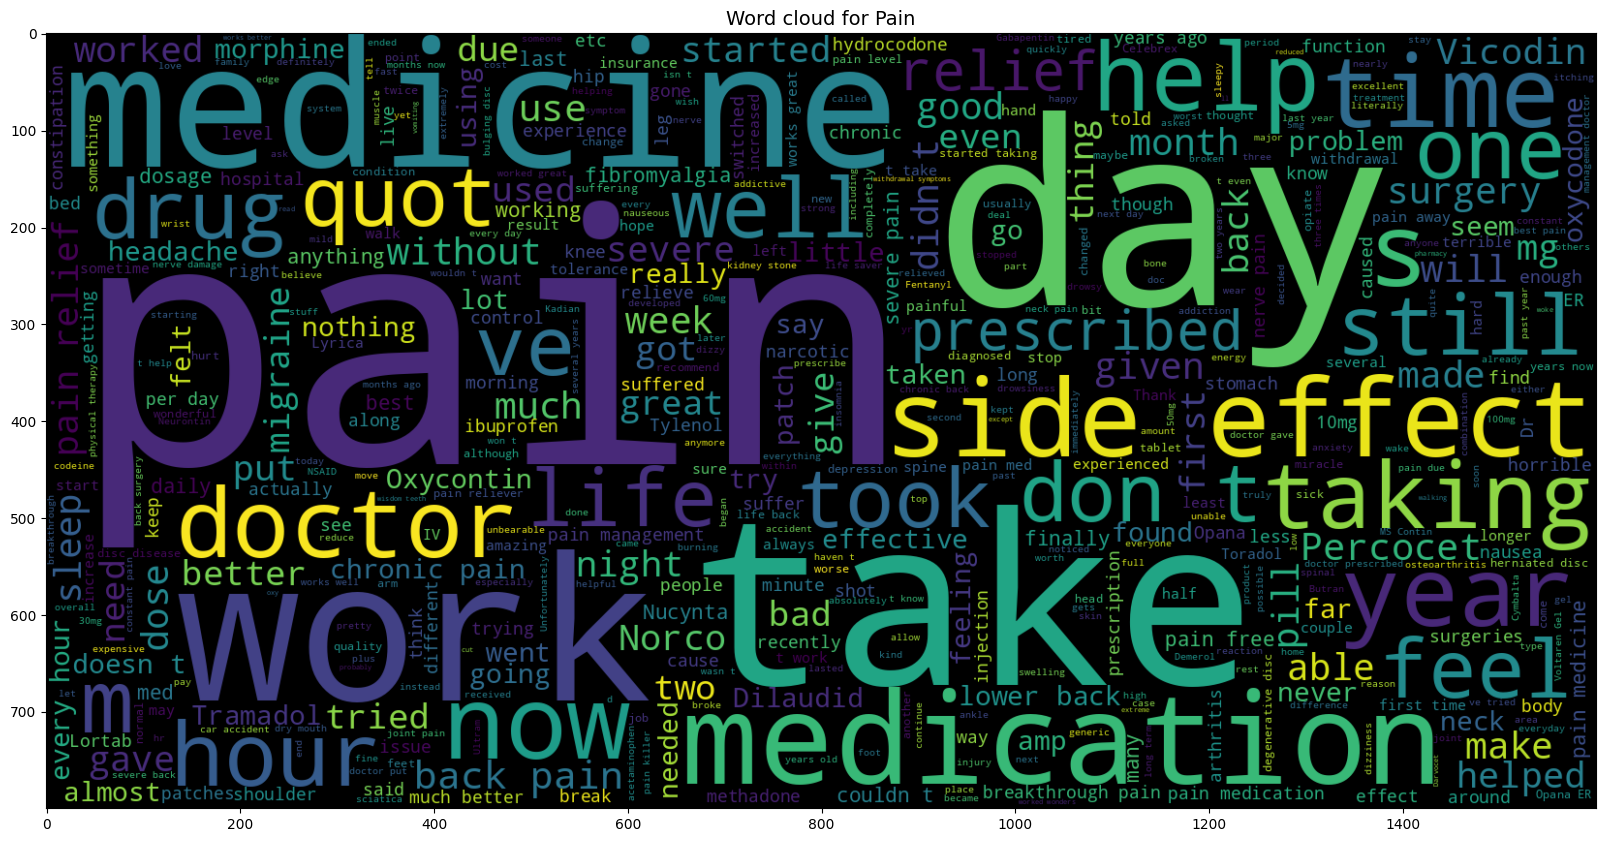

In [26]:
plt.figure(figsize=(20,20)) 
wc= WordCloud(max_words=500, width=1600, height=800).generate(" ".join(X_pain.review))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word cloud for Pain',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Diabetes Type 2')

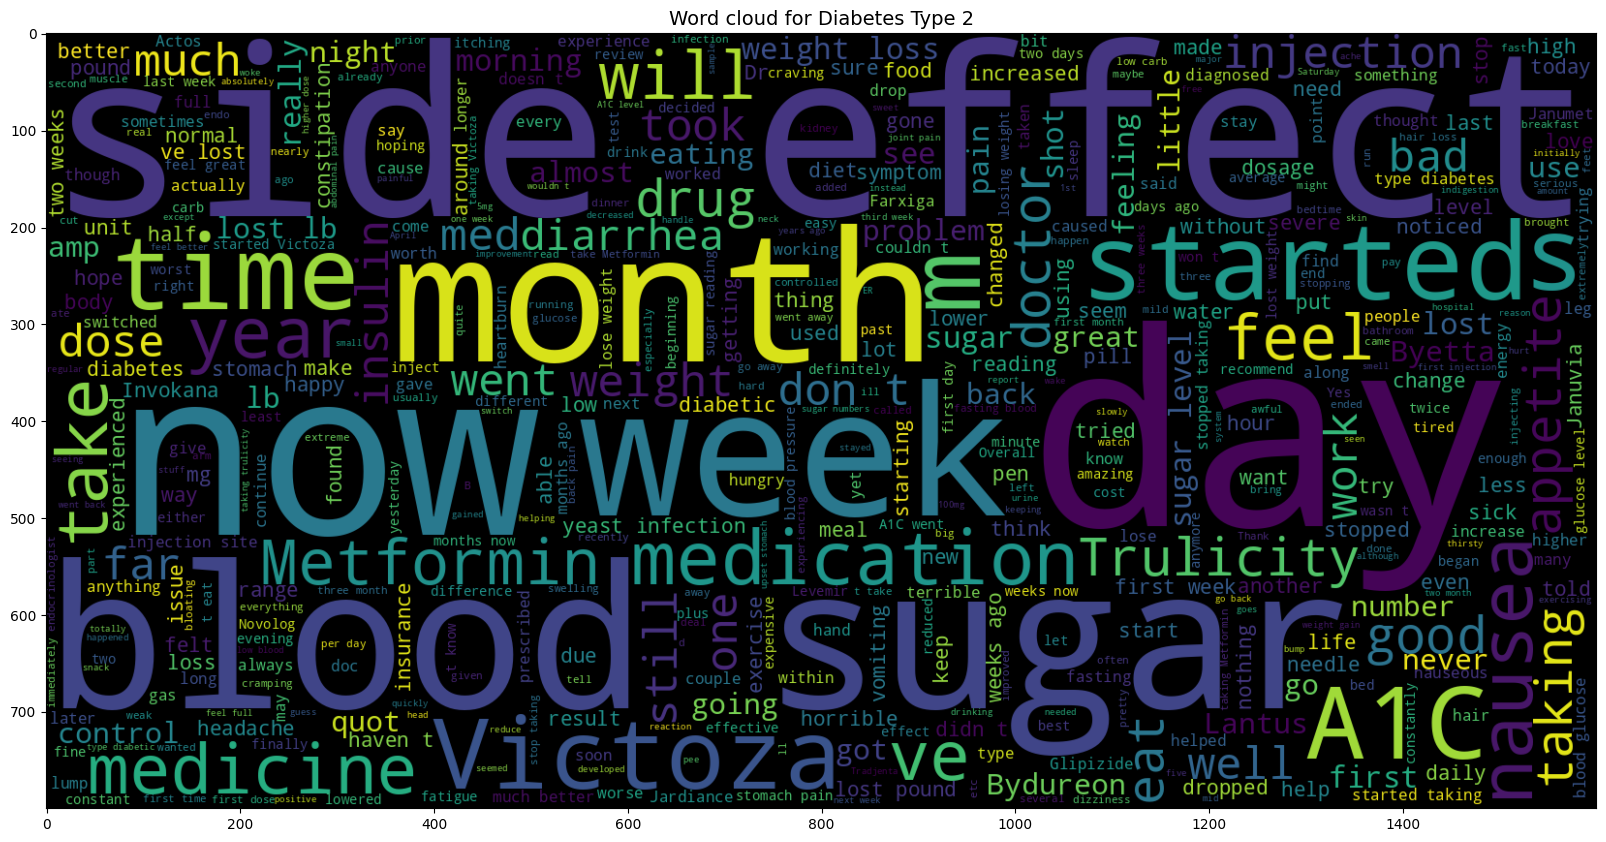

In [27]:
plt.figure(figsize=(20,20)) 
wc= WordCloud(max_words=500, width=1600, height=800).generate(" ".join(X_diab.review))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word cloud for Diabetes Type 2',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Erectile Dysfunction')

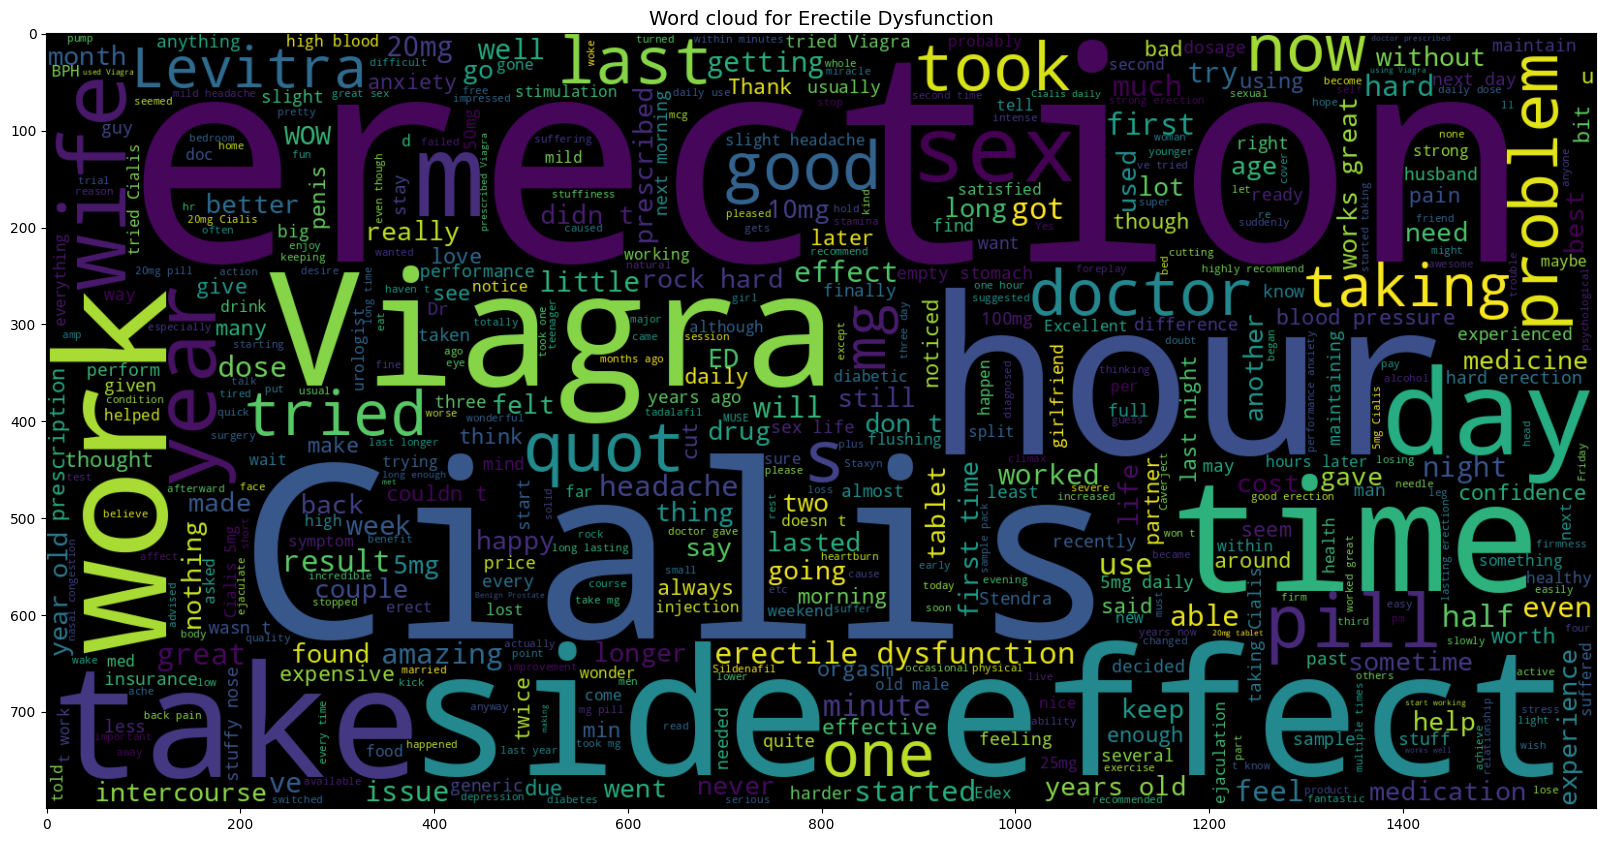

In [28]:
plt.figure(figsize=(20,20)) 
wc= WordCloud(max_words=500, width=1600, height=800).generate(" ".join(X_erec.review))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word cloud for Erectile Dysfunction',fontsize=14)

# Processamento dos dados

In [29]:
# Visualizando um review
X_aula['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

## Procedimento 1
Devemos retirar essas aspas dos textos. Elas não tem nenhuma função na análise de sentimentos

In [30]:
for i, col in enumerate(X_aula.columns):
  for j in range(X_aula.shape[0]):
    X_aula.iloc[j,i]=X_aula.iloc[j,i].replace('"',' ')
  

In [31]:
for i, col in enumerate(X_meu.columns):
    for j in range(X_meu.shape[0]):
      X_meu.iloc[j,i]=X_meu.iloc[j,i].replace('"',' ')

Obs: Não é necessário utilizar modo 'str',é necessário apenas colocar replace. Não conseguirepliar ocódigo da aula, então fiz um loop aninhado.

In [32]:
X_aula.head()

condition                                             review
2   Birth Control   I used to take another oral contraceptive, wh...
3   Birth Control   This is my first time using any form of birth...
9   Birth Control   I had been on the pill for many years. When m...
11     Depression   I have taken anti-depressants for years, with...
14  Birth Control   Started Nexplanon 2 months ago because I have...

In [33]:
X_aula.tail()

condition                                             review
161273        Birth Control   I have had the Nexplanon since Dec. 27, 2016 ...
161278     Diabetes, Type 2   I just got diagnosed with type 2. My doctor p...
161286           Depression   This is the third med I&#039;ve tried for anx...
161290  High Blood Pressure   I have only been on Tekturna for 9 days. The ...
161291        Birth Control   This would be my second month on Junel. I&#03...

In [34]:
X_meu.tail()

condition  \
161229                  Pain   
161231                  Pain   
161254  Erectile Dysfunction   
161256                  Pain   
161282  Erectile Dysfunction   

                                                   review  
161229   I was diagnosed with a rare form of Lupus (as...  
161231   Lumbar fusion, cervical fusion. 12 years of o...  
161254   After years of flopping about  at 52 I spoke ...  
161256   I have had both knees arthroscopic in the las...  
161282   I&#039;m a 59 year old male who has experienc...

In [35]:
X_meu.head()

condition                                             review
6   Emergency Contraception   He pulled out, but he cummed a bit in me. I t...
32                     Pain   I am 30 years old. I had a multiple composite...
37                     Pain   I have been on morphine for at least 7 years....
52                     Pain   My pain management doctor put me on Butrans p...
62                     Pain   I love my Butrans patch!!! And it has relieve...

## Processamento 2 - Stop Words
Stop Words são palavras que são utilizadas de fora recorrente em um idioma. <br />

A decisão de manter elas no corpus varia com o projet que está sendo criado.

Em projetos onde o modelos deve realizar analise de sentimentos, o ideal é remove-las, pois não acrecentam valor na diferenão.

Entretanto, elas podem ser uteis em outros modelos de liguagem, pincipal naquelas que o contexto importa.

Artigos importantes:



* [Agencia Mestre](https://www.agenciamestre.com/seo/stop-words-como-funcionam-palavras-de-parada/) dá exemploS da importância de stop words in SEO

* [Winsdow ML](https://wisdomml.in/what-are-stopwords-in-nlp-and-why-we-should-remove-them/), em inglês, fez uma artigo explicando muito bem as stopwords, o fundamento teoricos, códigos de exmplos de como remove-las e nos casos que é importante mante-las.





In [36]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # É necessário baixar esses dados

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
stop=stopwords.words('english')

In [38]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Lematização

O site [Clube do Português](https://www.clubedoportugues.com.br/lematizacao-e-stematizacao/) publicou um artigo simples e bastante didática do que é a lematização e sua diferença da Stemização.

Em resumo, ambas são formas de reduzir palavras a formas mais fácies de sere analizadas.

Entretanto, a lematização por reduzir palavras de raízes proximas ao mesmo token, preserva parte do seu sentido semântico. Sendo mais aproveitada em análises do sentimento.

In [39]:
#Lematizador: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
from nltk.stem import WordNetLemmatizer

#Stemmeatizador: https://www.nltk.org/howto/stem.html
from nltk.stem import PorterStemmer


In [40]:
porter = PorterStemmer()
lemmatizer=WordNetLemmatizer()


In [41]:
print(porter.stem("sportingly"))
print(porter.stem("very"))
print(porter.stem("troubled"))

sportingli
veri
troubl


In [42]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [43]:
print(lemmatizer.lemmatize("sportingly"))
print(lemmatizer.lemmatize("very"))
print(lemmatizer.lemmatize("troubled"))

sportingly
very
troubled


In [44]:
from bs4 import BeautifulSoup
import re

A biblioteca `re` é utiizada para expressões regulares.

A BeautifulSoup é uma das principais bibliotecas webscrapping em python. Por isso, ela tem uma série de funções para lidar simbolos de web/html/css/javascript, presentes nessas reviews.


In [45]:
def review_to_words(raw_review):
  # Delete Html
  review_text= BeautifulSoup(raw_review,'html.parser').get_text()
  # Make a space
  letter_only =re.sub('[^a-zA-Z]',' ',review_text)
  # Lower letters
  words=letter_only.lower().split()
  # Stopwords
  meaningful_words=[w for w in words if not w in stop]
  # Lemmitiation
  lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
  # space join words
  return(' '.join(lemmitize_words))

In [46]:
X_aula['review_clean'] = X_aula['review'].apply(review_to_words)
X_meu['review_clean'] = X_meu['review'].apply(review_to_words)


<ipython-input-45-80e9fb92dd92>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text= BeautifulSoup(raw_review,'html.parser').get_text()
<ipython-input-45-80e9fb92dd92>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text= BeautifulSoup(raw_review,'html.parser').get_text()


In [47]:
X_aula.head()

condition                                             review  \
2   Birth Control   I used to take another oral contraceptive, wh...   
3   Birth Control   This is my first time using any form of birth...   
9   Birth Control   I had been on the pill for many years. When m...   
11     Depression   I have taken anti-depressants for years, with...   
14  Birth Control   Started Nexplanon 2 months ago because I have...   

                                         review_clean  
2   used take another oral contraceptive pill cycl...  
3   first time using form birth control glad went ...  
9   pill many year doctor changed rx chateal effec...  
11  taken anti depressant year improvement mostly ...  
14  started nexplanon month ago minimal amount con...

In [48]:
X_meu.head()

condition  \
6   Emergency Contraception   
32                     Pain   
37                     Pain   
52                     Pain   
62                     Pain   

                                               review  \
6    He pulled out, but he cummed a bit in me. I t...   
32   I am 30 years old. I had a multiple composite...   
37   I have been on morphine for at least 7 years....   
52   My pain management doctor put me on Butrans p...   
62   I love my Butrans patch!!! And it has relieve...   

                                         review_clean  
6   pulled cummed bit took plan b hour later took ...  
32  year old multiple composite spinal injury year...  
37  morphine least year medicine seems manage pain...  
52  pain management doctor put butrans patch week ...  
62  love butrans patch relieved half pain know tak...

# Separando em variavel preditora e resposta

In [49]:
aula_feat=X_aula['review_clean']
aula_resposta=X_aula['condition']

In [50]:
meu_feat=X_meu['review_clean']
meu_resposta=X_meu['condition']

# Separando em treino e teste

In [51]:
aula_feat_treino, aula_feat_teste, aula_resposta_treino, aula_resposta_teste = train_test_split(aula_feat,
                                                                                                aula_resposta,
                                                                                                stratify=aula_resposta,
                                                                                                test_size=0.2,
                                                                                                random_state=0)

In [52]:
meu_feat_treino, meu_feat_teste, meu_resposta_treino, meu_resposta_teste = train_test_split(meu_feat,
                                                                                                meu_resposta,
                                                                                                stratify=meu_resposta,
                                                                                                test_size=0.2,
                                                                                                random_state=0)

# Função para a matriz de confusão

In [141]:
def plot_confusion_matrix(cm,classes,
                           normalize=False,
                           title='Matriz de Confusão',
                           cmap=plt.cm.YlOrBr):
  
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar() # gera uma barra de cores ao lado do grafico, proporcional ao valor de observações
  tick_marks= np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=-85)
  plt.yticks(tick_marks,classes)

  if normalize:
    cm = cm.astype('float') /cm.sum(axis=1)[:,np.newaxis]
    print("Matriz de confusão normalizada")
  else:
    print('Matriz de confusão sem normaliação')

  thresh=cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,round(cm[i,j],2),
             horizontalalignment='center',
             color='silver' if cm[i,j]> thresh else 'black')
    
  plt.tight_layout()
  plt.ylabel('Classe Correta')
  plt.xlabel('Classe Predita')


# Bag of Words 

Este artigo tem uma explicação breve da [Bag of Words](https://medium.com/turing-talks/introdu%C3%A7%C3%A3o-a-bag-of-words-e-tf-idf-43a128151ce9)

In [70]:
count_vectorizer = CountVectorizer(stop_words='english')

count_treino_aula=count_vectorizer.fit_transform(aula_feat_treino)
count_teste_aula=count_vectorizer.transform(aula_feat_teste)

count_treino_meu=count_vectorizer.fit_transform(meu_feat_treino)
count_teste_meu=count_vectorizer.transform(meu_feat_teste)

#fit_transform: Learn the vocabulary dictionary and return document-term matrix.
#transform: Transform documents to document-term matrix.

# Modelo Naive Bayes

O modelo de Naive Bayes, se utiliza do teorema de Bayes. Este teorema calcual a probalidade de algo, baseado em dados pre-existentes.

[Artigo do Sklearn](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes)

[Artigo do Sakurai Dev](https://www.sakurai.dev.br/classificacao-naive-bayes/)

acúracia: 0.970
Matriz de confusão normalizada


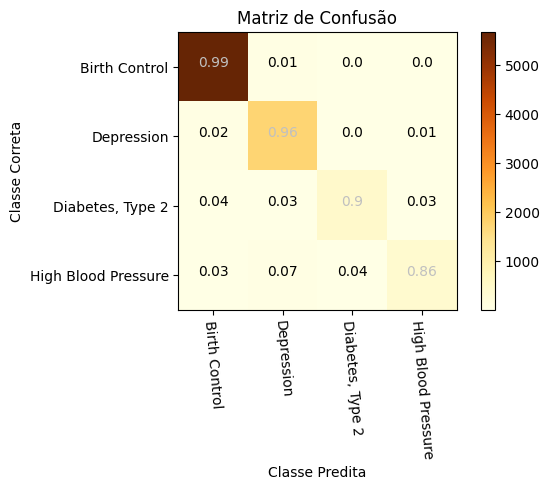

In [142]:
mnb_aula=MultinomialNB()
mnb_aula.fit(count_treino_aula,aula_resposta_treino)
pred_aula=mnb_aula.predict(count_teste_aula)
score_aula = metrics.accuracy_score(aula_resposta_teste, pred_aula)
print(f'acúracia: {score_aula:0.3f}')

aula_variables= ['Birth Control','Depression','Diabetes, Type 2','High Blood Pressure']

cm=metrics.confusion_matrix(aula_resposta_teste,
                            pred_aula,
                            labels=['Birth Control','Depression','Diabetes, Type 2','High Blood Pressure']
                            )
plot_confusion_matrix(cm,classes=['Birth Control','Depression','Diabetes, Type 2','High Blood Pressure'],normalize=True)


acúracia: 0.963
Matriz de confusão sem normaliação


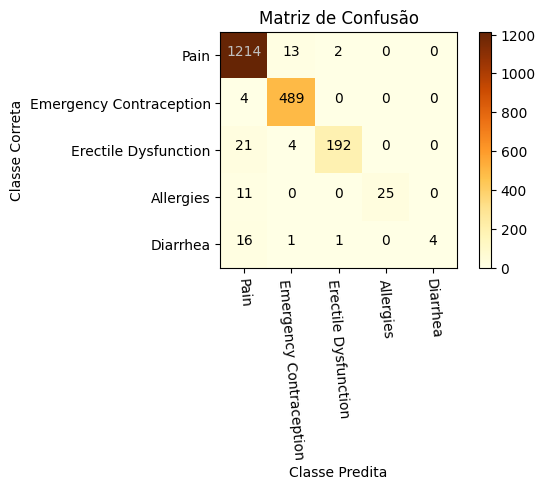

In [143]:
mnb_meu=MultinomialNB()
mnb_meu.fit(count_treino_meu,meu_resposta_treino)
pred_meu=mnb_meu.predict(count_teste_meu)
score_meu = metrics.accuracy_score(meu_resposta_teste, pred_meu)
print(f'acúracia: {score_meu:0.3f}')

meu_variables=['Pain',                       
'Emergency Contraception',    
'Erectile Dysfunction',      
'Allergies',                   
'Diarrhea']

cm=metrics.confusion_matrix(meu_resposta_teste,
                            pred_meu,
                            labels=meu_variables
                            )
plot_confusion_matrix(cm,classes=meu_variables)


# Passive Agressive Classifier

In [144]:
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression


acúracia: 0.978
Matriz de confusão sem normaliação


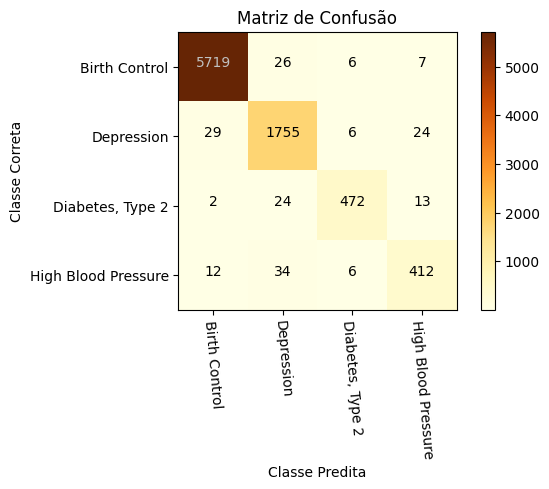

In [145]:
passive=PassiveAggressiveClassifier()
passive.fit(count_treino_aula, aula_resposta_treino)
pred_aula=passive.predict(count_teste_aula)
score_aula=metrics.accuracy_score(aula_resposta_teste,pred_aula)

print(f'acúracia: {score_aula:0.3f}')

cm=metrics.confusion_matrix(aula_resposta_teste,
                            pred_aula,
                            labels=aula_variables
                            )
plot_confusion_matrix(cm,classes=aula_variables)


acúracia: 0.964
Matriz de confusão normalizada


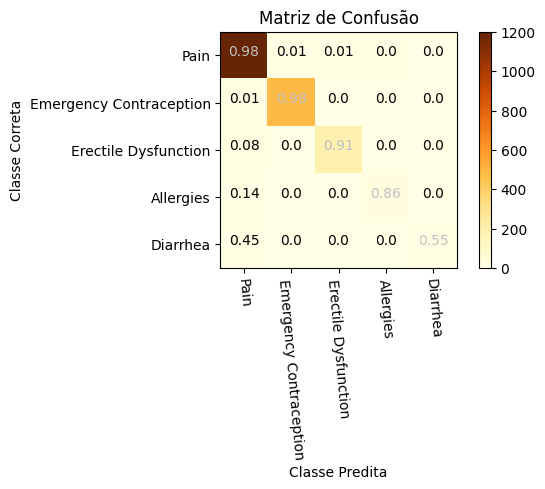

In [156]:
passive=PassiveAggressiveClassifier()
passive.fit(count_treino_meu, meu_resposta_treino)
pred_meu=passive.predict(count_teste_meu)
score_meu=metrics.accuracy_score(meu_resposta_teste,pred_meu)

print(f'acúracia: {score_meu:0.3f}')

cm=metrics.confusion_matrix(meu_resposta_teste,
                            pred_meu,
                            labels=meu_variables
                            )
plot_confusion_matrix(cm,classes=meu_variables,normalize=True)

# TFIDF

In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.8)
tf_aula_treino=tfidf_vectorizer.fit_transform(aula_feat_treino)
tf_aula_teste=tfidf_vectorizer.transform(aula_feat_teste)

tf_meu_treino=tfidf_vectorizer.fit_transform(meu_feat_treino)
tf_meu_teste=tfidf_vectorizer.transform(meu_feat_teste)


# Modelo Naive Bayes

acúracia: 0.921
Matriz de confusão sem normaliação


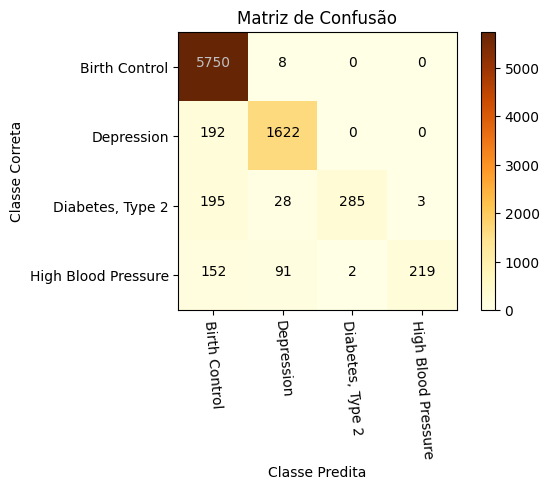

In [168]:
mnb_tf=MultinomialNB()
mnb_tf.fit(tf_aula_treino, aula_resposta_treino)
pred_aula=mnb_tf.predict(tf_aula_teste)
score_aula=metrics.accuracy_score(aula_resposta_teste,pred_aula)

print(f'acúracia: {score_aula:0.3f}')

cm=metrics.confusion_matrix(aula_resposta_teste,
                            pred_aula,
                            labels=aula_variables
                            )
plot_confusion_matrix(cm,classes=aula_variables)


acúracia: 0.920
Matriz de confusão sem normaliação


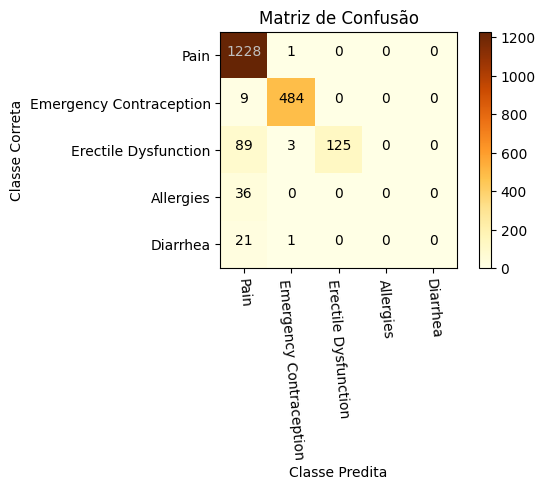

In [167]:
mnb_tf=MultinomialNB()
mnb_tf.fit(tf_meu_treino, meu_resposta_treino)
pred_meu=mnb_tf.predict(tf_meu_teste)
score_meu=metrics.accuracy_score(meu_resposta_teste,pred_meu)

print(f'acúracia: {score_meu:0.3f}')

cm=metrics.confusion_matrix(meu_resposta_teste,
                            pred_meu,
                            labels=meu_variables
                            )
plot_confusion_matrix(cm,classes=meu_variables)

# TFIDF: Bigrams

In [169]:
tfidf_vectorizer_bigrams=TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))

tfidf_bigram_aula_treino=tfidf_vectorizer_bigrams.fit_transform(aula_feat_treino)
tfidf_bigram_aula_teste=tfidf_vectorizer_bigrams.transform(aula_feat_teste)

tfidf_bigram_meu_treino=tfidf_vectorizer_bigrams.fit_transform(meu_feat_treino)
tfidf_bigram_meu_teste=tfidf_vectorizer_bigrams.transform(meu_feat_teste)

acúracia: 0.986
Matriz de confusão sem normaliação


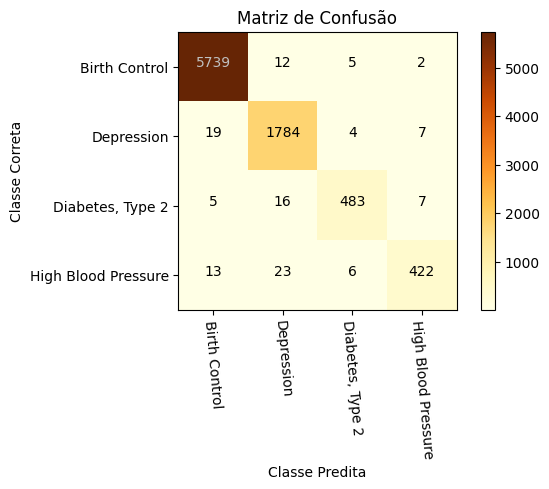

In [173]:
pass_tf= PassiveAggressiveClassifier()
pass_tf.fit(tfidf_bigram_aula_treino, aula_resposta_treino)
pred_aula=pass_tf.predict(tfidf_bigram_aula_teste)

score_aula=metrics.accuracy_score(aula_resposta_teste,pred_aula)

print(f'acúracia: {score_aula:0.3f}')

cm=metrics.confusion_matrix(aula_resposta_teste,
                            pred_aula,
                            labels=aula_variables
                            )
plot_confusion_matrix(cm,classes=aula_variables)


acúracia: 0.981
Matriz de confusão sem normaliação


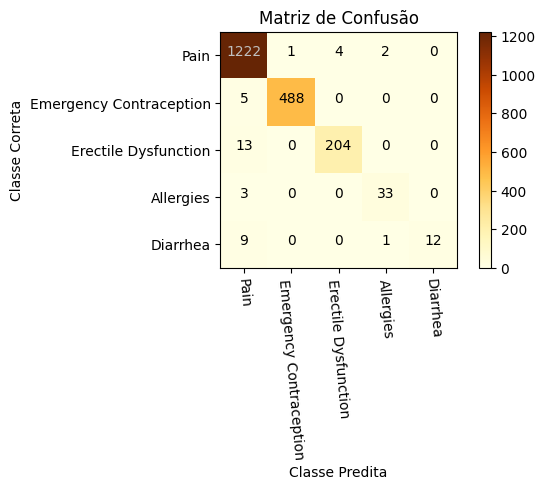

In [171]:
pass_tf= PassiveAggressiveClassifier()
pass_tf.fit(tfidf_bigram_meu_treino, meu_resposta_treino)
pred_meu=pass_tf.predict(tfidf_bigram_meu_teste)

score_meu=metrics.accuracy_score(meu_resposta_teste,pred_meu)

print(f'acúracia: {score_meu:0.3f}')

cm=metrics.confusion_matrix(meu_resposta_teste,
                            pred_meu,
                            labels=meu_variables
                            )
plot_confusion_matrix(cm,classes=meu_variables)

# TFIDF: Trigrams

In [240]:
tfidf_vectorizer_trigrams=TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))

tfidf_trigram_aula_treino=tfidf_vectorizer_trigrams.fit_transform(aula_feat_treino)
tfidf_trigram_aula_teste=tfidf_vectorizer_trigrams.transform(aula_feat_teste)

tfidf_trigram_meu_treino=tfidf_vectorizer_trigrams.fit_transform(meu_feat_treino)
tfidf_trigram_meu_teste=tfidf_vectorizer_trigrams.transform(meu_feat_teste)

acúracia: 0.986
Matriz de confusão sem normaliação


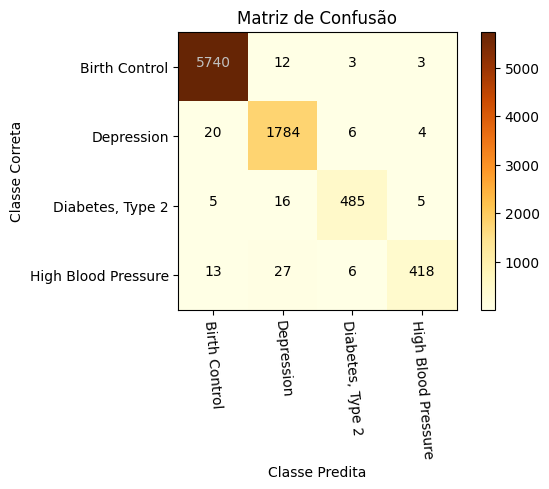

In [241]:
pass_tf_aula= PassiveAggressiveClassifier()
pass_tf_aula.fit(tfidf_trigram_aula_treino, aula_resposta_treino)
pred_aula=pass_tf_aula.predict(tfidf_trigram_aula_teste)

score_aula=metrics.accuracy_score(aula_resposta_teste,pred_aula)

print(f'acúracia: {score_aula:0.3f}')

cm=metrics.confusion_matrix(aula_resposta_teste,
                            pred_aula,
                            labels=aula_variables
                            )
plot_confusion_matrix(cm,classes=aula_variables)


acúracia: 0.982
Matriz de confusão sem normaliação


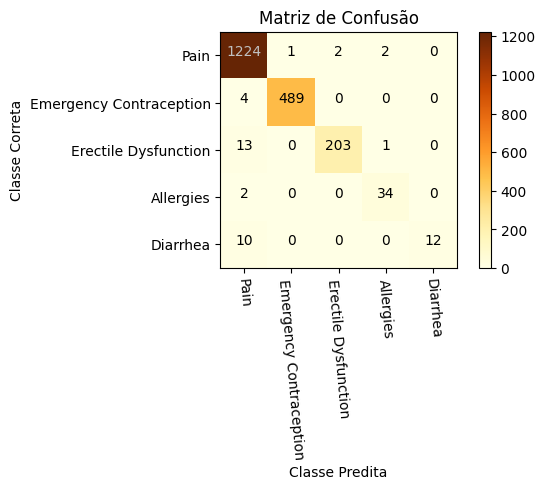

In [242]:
pass_tf_meu= PassiveAggressiveClassifier()
pass_tf_meu.fit(tfidf_trigram_meu_treino, meu_resposta_treino)
pred_meu=pass_tf_meu.predict(tfidf_trigram_meu_teste)

score_meu=metrics.accuracy_score(meu_resposta_teste,pred_meu)

print(f'acúracia: {score_meu:0.3f}')

cm=metrics.confusion_matrix(meu_resposta_teste,
                            pred_meu,
                            labels=meu_variables
                            )
plot_confusion_matrix(cm,classes=meu_variables)

# Most Important Features

In [185]:
def most_informative_feature_for_class (vectorizer,classifier,classlabel,n=10):
  labelid= list(classifier.classes_).index(classlabel)
  feature_names=vectorizer.get_feature_names_out()
  topn=sorted(zip(classifier.coef_[labelid],feature_names))[-n:]

  for coef, feat in topn:
    print(classlabel,feat, coef)


In [186]:
most_informative_feature_for_class(tfidf_vectorizer,pass_tf_aula,'Birth Control')

Birth Control creates 0.3702405373319098
Birth Control fioricet 0.37930112554813145
Birth Control desensitised 0.42339797374699634
Birth Control creepy 0.44632643946070744
Birth Control fault 0.47378445992434154
Birth Control egg 0.5222670577255426
Birth Control alter 0.6306839330753206
Birth Control age 0.6640700352600406
Birth Control eliminates 1.2872015187052421
Birth Control originating 6.926536600988896


In [189]:
most_informative_feature_for_class(tfidf_vectorizer,pass_tf_aula,'Diabetes, Type 2')

Diabetes, Type 2 link 0.3176271752039609
Diabetes, Type 2 linked 0.3176271752039609
Diabetes, Type 2 lotronex 0.338434441969928
Diabetes, Type 2 alter 0.3449797078967028
Diabetes, Type 2 md 0.3510005551326491
Diabetes, Type 2 meal 0.3510005551326491
Diabetes, Type 2 nuchal 0.3567460527579238
Diabetes, Type 2 access 0.4181108918491769
Diabetes, Type 2 ceiling 0.458125317158115
Diabetes, Type 2 operation 0.7510758371277608


In [187]:
most_informative_feature_for_class(tfidf_vectorizer,pass_tf_meu,'Pain')

Pain population 0.5735558475081644
Pain virgintiy 0.5741324958015285
Pain suppressed 0.5794028210360896
Pain harsh 0.648416654190993
Pain explanation 0.6586815053288626
Pain solved 0.706619670787586
Pain skirt 0.745282162422983
Pain guarantee 0.8572399610524554
Pain pudendal 0.880655966068002
Pain focusing 1.0117636729583173


In [190]:
most_informative_feature_for_class(tfidf_vectorizer,pass_tf_meu,'Allergies')

Allergies burn 0.4731615092426329
Allergies exparel 0.47998550037060983
Allergies expect 0.47998550037060983
Allergies trail 0.4810838534453586
Allergies train 0.4810838534453586
Allergies rank 0.6514061467459833
Allergies ray 0.8807907549808976
Allergies traffic 1.0467335894227254
Allergies replace 1.245719795221935
Allergies reflux 6.760198916666028


# Amostras para teste

In [191]:
sample=pd.read_csv('/content/drugsComTest_raw.tsv', sep='\t')

In [269]:
df_teste=sample[(sample['condition']=='Erectile Dysfunction') | (sample['condition']=='Sinusitis ') | (sample['condition']=='Diarrhea') | (sample['condition']=='Emergency Contraception') | (sample['condition']=='Pain') | (sample['condition']=='Allergies') | (sample['condition']=='Birth Control') | (sample['condition']=='Depression') | (sample['condition']=='High Blood Pressure') | (sample['condition']=='Diabetes, Type 2')]

In [268]:
df_teste2=sample[(sample['condition']=='Birth Control') | (sample['condition']=='Depression') | (sample['condition']=='High Blood Pressure') | (sample['condition']=='Diabetes, Type 2')]

In [259]:
df_teste.iloc[0].review

'"Been on 30mg Cymbalta for 2 weeks. Started getting relief by the 2nd day. Am 58 year old male with spinal stenosis, degenerative disc disease, and spondy. Plan was to go to 60mg but I am getting enough relief at 30mg. I believe I will try to stay on that dose to minimize side effects. Some constipation, difficult reaching orgasm, some night sweats and minor headaches. Oh, insomnia if I took it at night.  I had samples of this medicine for 6 months but delayed starting it because of horror stories on the internet. Pain was ruining my life so this medicine seems to be the best option."'

In [260]:
def sample_classification(text):
  new_text=text.replace('"',' ')
  new_text=review_to_words(new_text)
  return list(new_text)

In [270]:
choice=df_teste2.iloc[2]
text= sample_classification(choice.review)
test=tfidf_vectorizer_trigrams.transform(text)
test.shape
pred1=pass_tf_aula.predict(test)[0]
print(pred1)
print(choice.condition)

ValueError: ignored